# Setup

***Modules***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from scipy.stats import linregress
import scipy.stats as stats
import datetime
import pickle
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa import stattools
from trendmaster import trend
from pathlib import Path

***Loading data***

In [2]:
def saveDict(dictionary,filename):
    """
    Saves dictionary to pickle file in working directory.
    
    Parameters
    ----------
    dictionary: dict
    filename: str
        filename without .pkl ending
    
    Returns
    -------
    Nothing
    """
    f = open(f"{filename}.pkl","wb")
    pickle.dump(dictionary,f)
    f.close()

def openDict(filename):
    """
    Opens dictionary from pickle file in working directory.
    
    Parameters
    ----------
    filename: str
        filename without .pkl ending
    
    Returns
    -------
    dictionary
    """
    pickle_in = open(f"{filename}.pkl","rb")
    loadedDict = pickle.load(pickle_in)
    return loadedDict

In [3]:
sor = openDict("sorlandet_final")
ost = openDict("ostlandet_final")
vest = openDict("vestlandet_final")
trond = openDict("trondelag_final")
nord = openDict("nordland_final")
finn = openDict("finnmark_final")

In [4]:
streamflow30 = openDict("MA_streamflow_30year")

In [5]:
def reshapeToArray(data,MA,period=30):
    """
    Reshapes moving average smoothed data from dictionary to array.
    
    Parameters
    ----------
    data: dictionary
        for a certain region, containing 30 year timeseries for different moving averages
    MA: str
        {"5day","10day","30day"}
    
    Returns
    -------
    numpy.array
        array of shape (doy,year,catchment) with the catchments ordered by altitude
    """
    doy = np.arange(365)
    start = 2013-int(period)
    years = np.arange(start,2013)
    catchments = list(data.keys())
    x = len(catchments)
    # array with shape: doy,year,catchment
    arr = np.full((len(doy),len(years),x),np.nan)
    # filling array
    for c in range(x):
        for y in years:
            for d in doy:
                arr[d,y-start,c] = data[catchments[c]][MA][f"{y}"][d]
    return(arr)

# Autocorrelation

* Finds timeseries with significant lag-1 autocorrelation.
* These functions were incorporated into the runTrendAnalysis and runTrendMagnitude scripts.


In [6]:
def autocorrTest(ts,alpha=0.05):
    """
    Ljung-Box test for significant autocorrelation in a time series.
    """
    acf, qstat, p = stattools.acf(ts,qstat=True,nlags=1)
    p = p[0]
    sign = p < alpha
    return sign

def prewhiten(ts):
    """
    Pre-whitening procedure of a time series.

    After Wang&Swail, 2001:
    https://doi.org/10.1175/1520-0442(2001)014%3C2204:COEWHI%3E2.0.CO;2
    """
    r = stattools.acf(ts,nlags=1)[1]
    pw = ts.copy()
    for i in range(ts.shape[0]-1):
        if i > 0:
            pw[i] = (ts[i] - r*ts[i-1])/(1 - r)
    return pw

# Cross-correlation

Field signifcance after Burn and Hag Elnur 2002

## Daily trends

In [6]:
def reshapeToArray(data,MA,period=30):
    """
    Reshapes moving average smoothed data from dictionary to array.
    
    Parameters
    ----------
    data: dictionary
        for a certain region, containing 30 year timeseries for different moving averages
    MA: str
        {"5day","10day","30day"}
    
    Returns
    -------
    numpy.array
        array of shape (doy,year,catchment) with the catchments ordered by altitude
    """
    doy = np.arange(365)
    start = 2013-int(period)
    years = np.arange(start,2013)
    catchments = list(data.keys())
    x = len(catchments)
    # array with shape: doy,year,catchment
    arr = np.full((len(doy),len(years),x),np.nan)
    # filling array
    for c in range(x):
        for y in years:
            for d in doy:
                arr[d,y-start,c] = data[catchments[c]][MA][f"{y}"][d]
    return(arr)

Made into script to create reshaped arrays.

In [8]:
def findFiles(variable="_",region="_",MA="day",years="year",resultDir="Reshaped"):
    """
    Finds .npy-files for a specific variable and moving average smoothing (MA) in a directory.
    
    Parameters
    ----------
    variable: str
    MA: str
    
    Returns
    -------
    list of files
    """
    # set folder
    folder = Path(resultDir)
    
    # make list of strings
    files = []
    for item in sorted(folder.glob(f"*{variable}*{region}*{MA}*{years}*.npy")):
        files.append(str(item))
    
    return files

def resamplingDaily(array):
    """
    Resampling procedure after Burn and Hag Elnur, 2002.
    
    Parameters
    ----------
    array: 3D numpy array in the shape (DOY,years,catchments)
    years: int
    MA: str
    
    Returns
    -------
    dataframe with resampled data
    """
    years = np.arange(0,array.shape[1])
    days = np.arange(0,array.shape[0])
    resampled = np.full_like(array,np.nan)
    for DOY in days:
        for i in range(len(years)):
            # select random year
            year = np.random.choice(years)
            # get values for that year
            resampled[DOY,i,:] = array[DOY,year,:]

    return resampled

def fieldSignDaily(array, alpha = 0.1, q = 90, NS = 500):
    """
    Calculating the field significance after Burn and Hag Elnur, 2002.
    """
    days = np.arange(0,array.shape[0])
    
    significant = []
    for i in range(NS):
        resampledArray = resamplingDaily(array)
        sign = np.full(resampledArray.shape[0],np.nan)
        for d in days:
            if np.isfinite(resampledArray[d,:,0]).all():
                s = 0
                for c in range(resampledArray.shape[2]):
                    p = trend.mann_kendall(resampledArray[d,:,c])
                    if p<alpha:
                        s += 1
                # proportion of catchments with signifcant trend
                sign[d] = s/resampledArray.shape[2]
        significant.append(sign)
    
    distribution = np.array(significant)
    
    pcrit = []
    for d in days:
        if np.isfinite(distribution[:,d]).all():
            pcrit.append(np.percentile(distribution[:,d],q))
        else:
            pcrit.append(np.nan)
    pcrit = np.array(pcrit)
    
    percentSign = []
    for d in days:
        s = 0
        for c in range(array.shape[2]):
            p = trend.mann_kendall(array[d,:,c])
            if p<alpha:
                s += 1
        percentSign.append(s/array.shape[2])
    percentSign = np.array(percentSign)
    
    output = {"pcrit":pcrit,"percentSign":percentSign,"fieldSignificant":percentSign>pcrit}
    return pd.DataFrame(output)

files = findFiles()
for file in files:
    array = np.load(file)
    var,region,MA,period = tuple(file.split("/")[-1].split(".")[0].split("_"))
    result = fieldSignDaily(array)
    result.to_csv(f"Results/fieldSignificance_{var}_{region}_{MA}_{period}.csv")

In [17]:
file = findFiles(variable="streamflow",MA="10",region="finn",years="30")[0]
array = np.load(file)

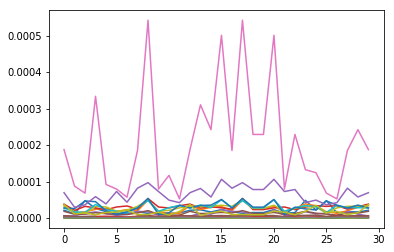

In [23]:
test = resamplingDaily(array)
for i in range(test.shape[2]):
    plt.plot(test[5,:,i])

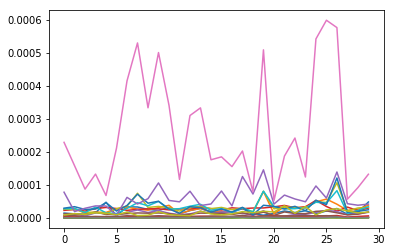

In [20]:
test = array
for i in range(test.shape[2]):
    plt.plot(test[5,:,i])

Made into script and run in terminal.